## 4.6 GAN(Generative Adversarial Network)

### 생성적 적대 신경망
* 새로운 결과물을 만들어 내는 생성 모델
* Ian Goodfellow(이안 굿펠로우) 논문
* 응용 사례
* 고흐풍의 그림을 그리는 페이터
* 흑백 사진을 컬러 사진으로
* 가려진 신체 부분 복원
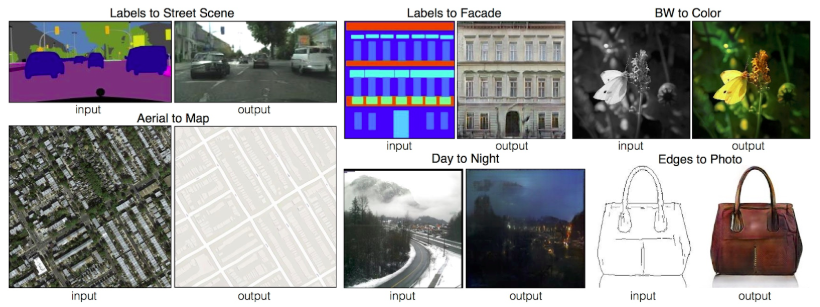

### 학습방법
* 서로 대립하는 두 신경망을 경쟁시켜서 생성 방법 학습
    * 위조지폐범 vs 경찰
    * Noise 발생해서 Generator 에게 입력해서 얻은 결과
    * Discriminator가 진짜와 가짜를 구분
    * 진짜 쪽에 가까운것을 만드는 Generator 훈련
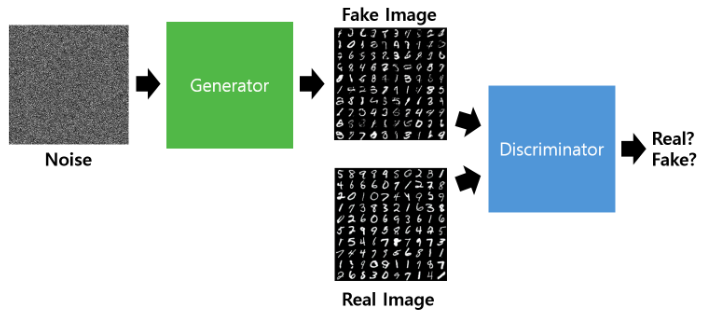

### 손글씨 숫자 생성 예제


In [2]:
# 2016년에 가장 관심을 많이 받았던 비감독(Unsupervised) 학습 방법인
# Generative Adversarial Network(GAN)을 구현해봅니다.
# https://arxiv.org/abs/1406.2661
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./mnist/data/", one_hot=True)

#########
# 옵션 설정
######
total_epoch = 100
batch_size = 100
learning_rate = 0.0002
# 신경망 레이어 구성 옵션
n_hidden = 256
n_input = 28 * 28
n_noise = 128  # 생성기의 입력값으로 사용할 노이즈의 크기

#########
# 신경망 모델 구성
######
# GAN 도 Unsupervised 학습이므로 Autoencoder 처럼 Y 를 사용하지 않습니다.
X = tf.placeholder(tf.float32, [None, n_input])
# 노이즈 Z를 입력값으로 사용합니다.
Z = tf.placeholder(tf.float32, [None, n_noise])

# 생성기 신경망에 사용하는 변수들입니다.
G_W1 = tf.Variable(tf.random_normal([n_noise, n_hidden], stddev=0.01))
G_b1 = tf.Variable(tf.zeros([n_hidden]))
G_W2 = tf.Variable(tf.random_normal([n_hidden, n_input], stddev=0.01))
G_b2 = tf.Variable(tf.zeros([n_input]))

# 판별기 신경망에 사용하는 변수들입니다.
D_W1 = tf.Variable(tf.random_normal([n_input, n_hidden], stddev=0.01))
D_b1 = tf.Variable(tf.zeros([n_hidden]))
# 판별기의 최종 결과값은 얼마나 진짜와 가깝냐를 판단하는 한 개의 스칼라값입니다.
D_W2 = tf.Variable(tf.random_normal([n_hidden, 1], stddev=0.01))
D_b2 = tf.Variable(tf.zeros([1]))


# 생성기(G) 신경망을 구성합니다.
def generator(noise_z):
    hidden = tf.nn.relu(
                    tf.matmul(noise_z, G_W1) + G_b1)
    output = tf.nn.sigmoid(
                    tf.matmul(hidden, G_W2) + G_b2)

    return output


# 판별기(D) 신경망을 구성합니다.
def discriminator(inputs):
    hidden = tf.nn.relu(
                    tf.matmul(inputs, D_W1) + D_b1)
    output = tf.nn.sigmoid(
                    tf.matmul(hidden, D_W2) + D_b2)

    return output


# 랜덤한 노이즈(Z)를 만듭니다.
def get_noise(batch_size, n_noise):
    return np.random.normal(size=(batch_size, n_noise))


# 노이즈를 이용해 랜덤한 이미지를 생성합니다.
G = generator(Z)
# 노이즈를 이용해 생성한 이미지가 진짜 이미지인지 판별한 값을 구합니다.
D_gene = discriminator(G)
# 진짜 이미지를 이용해 판별한 값을 구합니다.
D_real = discriminator(X)

# 논문에 따르면, GAN 모델의 최적화는 loss_G 와 loss_D 를 최대화 하는 것 입니다.
# 다만 loss_D와 loss_G는 서로 연관관계가 있기 때문에 두 개의 손실값이 항상 같이 증가하는 경향을 보이지는 않을 것 입니다.
# loss_D가 증가하려면 loss_G는 하락해야하고, loss_G가 증가하려면 loss_D는 하락해야하는 경쟁관계에 있기 때문입니다.
# 논문의 수식에 따른 다음 로직을 보면 loss_D 를 최대화하기 위해서는 D_gene 값을 최소화하게 됩니다.
# 판별기에 진짜 이미지를 넣었을 때에도 최대값을 : tf.log(D_real)
# 가짜 이미지를 넣었을 때에도 최대값을 : tf.log(1 - D_gene)
# 갖도록 학습시키기 때문입니다.
# 이것은 판별기는 생성기가 만들어낸 이미지가 가짜라고 판단하도록 판별기 신경망을 학습시킵니다.
loss_D = tf.reduce_mean(tf.log(D_real) + tf.log(1 - D_gene))
# 반면 loss_G 를 최대화하기 위해서는 D_gene 값을 최대화하게 되는데,
# 이것은 가짜 이미지를 넣었을 때, 판별기가 최대한 실제 이미지라고 판단하도록 생성기 신경망을 학습시킵니다.
# 논문에서는 loss_D 와 같은 수식으로 최소화 하는 생성기를 찾지만,
# 결국 D_gene 값을 최대화하는 것이므로 다음과 같이 사용할 수 있습니다.
loss_G = tf.reduce_mean(tf.log(D_gene))

# loss_D 를 구할 때는 판별기 신경망에 사용되는 변수만 사용하고,
# loss_G 를 구할 때는 생성기 신경망에 사용되는 변수만 사용하여 최적화를 합니다.
D_var_list = [D_W1, D_b1, D_W2, D_b2]
G_var_list = [G_W1, G_b1, G_W2, G_b2]

# GAN 논문의 수식에 따르면 loss 를 극대화 해야하지만, minimize 하는 최적화 함수를 사용하기 때문에
# 최적화 하려는 loss_D 와 loss_G 에 음수 부호를 붙여줍니다.
train_D = tf.train.AdamOptimizer(learning_rate).minimize(-loss_D,
                                                         var_list=D_var_list)
train_G = tf.train.AdamOptimizer(learning_rate).minimize(-loss_G,
                                                         var_list=G_var_list)

#########
# 신경망 모델 학습
######
sess = tf.Session()
sess.run(tf.global_variables_initializer())

total_batch = int(mnist.train.num_examples/batch_size)
loss_val_D, loss_val_G = 0, 0

for epoch in range(total_epoch):
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        noise = get_noise(batch_size, n_noise)

        # 판별기와 생성기 신경망을 각각 학습시킵니다.
        _, loss_val_D = sess.run([train_D, loss_D],
                                 feed_dict={X: batch_xs, Z: noise})
        _, loss_val_G = sess.run([train_G, loss_G],
                                 feed_dict={Z: noise})

    print('Epoch:', '%04d' % epoch,
          'D loss: {:.4}'.format(loss_val_D),
          'G loss: {:.4}'.format(loss_val_G))

    #########
    # 학습이 되어가는 모습을 보기 위해 주기적으로 이미지를 생성하여 저장
    ######
    if epoch == 0 or (epoch + 1) % 10 == 0:
        sample_size = 10
        noise = get_noise(sample_size, n_noise)
        samples = sess.run(G, feed_dict={Z: noise})

        fig, ax = plt.subplots(1, sample_size, figsize=(sample_size, 1))

        for i in range(sample_size):
            ax[i].set_axis_off()
            ax[i].imshow(np.reshape(samples[i], (28, 28)))

        plt.savefig('samples/{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
        plt.close(fig)

print('최적화 완료!')

Extracting ./mnist/data/train-images-idx3-ubyte.gz
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz
Epoch: 0000 D loss: -0.478 G loss: -2.119
Epoch: 0001 D loss: -0.1514 G loss: -3.116
Epoch: 0002 D loss: -0.2444 G loss: -2.888
Epoch: 0003 D loss: -0.6027 G loss: -1.448
Epoch: 0004 D loss: -0.5323 G loss: -1.478
Epoch: 0005 D loss: -0.4047 G loss: -2.042
Epoch: 0006 D loss: -0.2651 G loss: -2.556
Epoch: 0007 D loss: -0.2637 G loss: -2.201
Epoch: 0008 D loss: -0.2962 G loss: -2.38
Epoch: 0009 D loss: -0.3484 G loss: -2.414
Epoch: 0010 D loss: -0.4834 G loss: -2.088
Epoch: 0011 D loss: -0.4952 G loss: -1.98
Epoch: 0012 D loss: -0.4584 G loss: -2.104
Epoch: 0013 D loss: -0.4972 G loss: -1.781
Epoch: 0014 D loss: -0.6151 G loss: -1.816
Epoch: 0015 D loss: -0.4582 G loss: -2.219
Epoch: 0016 D loss: -0.3902 G loss: -2.55
Epoch: 0017 D loss: -0.366 G loss: -2.617
Epoch: 0018 D loss: -0.3741 G

KeyboardInterrupt: 

### 개구리 사진 생성 예제

#### 생성자

In [2]:
import keras
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# 입력을 16 × 16 크기의 128개 채널을 가진 특성 맵으로 변환합니다
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

# 합성곱 층을 추가합니다
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# 32 × 32 크기로 업샘플링합니다
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# 합성곱 층을 더 추가합니다
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# 32 × 32 크기의 1개 채널을 가진 특성 맵을 생성합니다
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv

#### 판별자

In [3]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# 드롭아웃 층을 넣는 것이 아주 중요합니다!
x = layers.Dropout(0.4)(x)

# 분류 층
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# 옵티마이저에서 (값을 지정하여) 그래디언트 클리핑을 사용합니다
# 안정된 훈련을 위해서 학습률 감쇠를 사용합니다
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)         262272    
___________________________

#### 적대적 네트워크

In [4]:
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

#### GAN 훈련

In [7]:
import os
from keras.preprocessing import image

# CIFAR10 데이터를 로드합니다
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# 개구리 이미지를 선택합니다(클래스 6)
x_train = x_train[y_train.flatten() == 6]

# 데이터를 정규화합니다
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = './datasets/gan_images/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

# 훈련 반복 시작
start = 0
for step in range(iterations):
    # 잠재 공간에서 무작위로 포인트를 샘플링합니다
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 가짜 이미지를 디코딩합니다
    generated_images = generator.predict(random_latent_vectors)

    # 진짜 이미지와 연결합니다
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # 진짜와 가짜 이미지를 구분하여 레이블을 합칩니다
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # 레이블에 랜덤 노이즈를 추가합니다. 아주 중요합니다!
    labels += 0.05 * np.random.random(labels.shape)

    # discriminator를 훈련합니다
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # 잠재 공간에서 무작위로 포인트를 샘플링합니다
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 모두 “진짜 이미지"라고 레이블을 만듭니다
    misleading_targets = np.zeros((batch_size, 1))

    # generator를 훈련합니다(gan 모델에서 discriminator의 가중치는 동결됩니다)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    # 중간 중간 저장하고 그래프를 그립니다
    if step % 100 == 0:
        # 모델 가중치를 저장합니다
        gan.save_weights('gan.h5')

        # 측정 지표를 출력합니다
        print('스텝 %s에서 판별자 손실: %s' % (step, d_loss))
        print('스텝 %s에서 적대적 손실: %s' % (step, a_loss))

        # 생성된 이미지 하나를 저장합니다
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # 비교를 위해 진짜 이미지 하나를 저장합니다
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

Instructions for updating:
Use tf.cast instead.


/Users/rainer/Dropbox/work/ml_dl/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


스텝 0에서 판별자 손실: 0.7014066
스텝 0에서 적대적 손실: 0.19502145


KeyboardInterrupt: 

#### 가짜 이미지 출력

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# 잠재 공간에서 랜덤한 포인트를 샘플링합니다
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# 가짜 이미지로 디코딩합니다
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()